# 0️⃣ Установка



In [1]:
if 1:
    # tf-agents 0.10 for tf 2.6, [reverb] - нужно указывать, чтобы установилась с ним
    # проблемы с зависимостями, tf-agent последний, притянет tf 2.9
    !pip install tf-agents==0.10.0

    # https://github.com/openai/gym/releases/tag/0.25.1
    !pip install gym #==0.25.1 

    # ROMS
    !pip install gym[atari]
    !pip install autorom[accept-rom-license]

    # Запись видео
    !pip install 'imageio==2.4.0'

    # !pip install pyglet
    # !pip install pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=446447 sha256=7b95dd31314cfed660216aadeeb4bf00c408beeb77ab1c47f8e16e40b973beb9
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for imageio: filename=imageio-2.4.0-py3-none-any.whl s

# 1️⃣ Импорты и Гиперпараметры

In [2]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# (train_step_counter) счётчик шагов,
# при проходе каждого шага обучения агента он увеличивается
global_step = tf.Variable(0)

2022-08-28 11:30:27.190074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 11:30:27.371581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 11:30:27.372439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 11:30:27.374821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# Настройки для env
env_name             = 'ALE/Pong-v5' # gym env name
max_episode_steps    = 0 # количество кадров, которые отдаёт gym env, НЕ используется
num_actions          = 6 # количество доступных действий (всего 6), выход из Dense слоя
frame_skip           = 8 # сколько кадров пропускать в env, по умолчанию 4


# +++++++++++++++++++
# Настройки Буфера и Dataset
# Буффер - содержаит транзакции: Состояние - Действие - Состояние
replay_buffer_max_length = 25_000  # Допустимый размер буфера (количество кадров) - GPU
# replay_buffer_max_length = 75_000  # Допустимый размер буфера (количество кадров) - CPU
initial_collect_steps    = 10_000  # Количество кадров, сколько нужно подгрузить в буфер (при инициализации)
batch_size_dataset       = 64      # Батч для dataset - GPU
batch_size_dataset       = 64      # Батч для dataset - CPU
prefetch_size            = 3       # Подгружаем в память вперёд указанное количество Батчей


# +++++++++++++++++++
# Настройка Агента
n_step_update            = 29      # Количество "кадров\действий", возвращается из dataset в одном батче
                                   # примерно 10 шагов (при пропуске 8 кадров) чтобы получить Награду: -1\+1
                                   # в dataset подаётся этот параметр, но увеличенный на +1
                                   # параметр называется tf_agent.train_sequence_length

        
# +++++++++++++++++++
# Настройка политики
# 10k шагов на рандомной политике, после начинается epselon-gredy
# Epsilon -  вероятность выбрать случайное действие, убывает с каждым шагом
start_epsilon     = 1.0 # начальное значение эпсилон 
end_epsilon       = 0.1 # конечное значение
n_of_steps        = 150_000 # количесвто шагов, за которые нужно изменить эпсилон

# +++++++++++++++++++
# Параметр дисконтирования
gamma             = 0.99


# +++++++++++++++++++
# Драйвер обеспечивает цикл игры
num_steps_agent_do_in_env = 2000  # количество шагов, которые нужно сделать в env при запуске run()
                                  # шаги запишутся в буфер, если он полный, то часть шагов будет замещена
learning_rate             = 0.001 # скорость обучения
target_update_period      = 1000  # синхранизация сетей в Агенте

# 2️⃣ Среда - `observation`

`tf_agents.environments` - модуль в котором собраны окружения для агента:
* `suite_gym` - Suite for loading Gym Environments. Происходит обёртка, чтобы получать `TimeLimit`, происходи корректировка последнего состояния\действия, чтобы получить дисконтированную награду (разная - игра завершена - победа \ поражение).
* `tf_agents.trajectories.TimeStep` - {step_type, reward, discount, observation} - объект возвращается на каждый reset, step.
    * `env.time_step_spec().observation` - состояние среды.
        * картинка (210, 160)
    * `env.time_step_spec().reward` - награды.
        * scalar float
    * `env.action_spec()` - допустимые шаги.
        * 0-5 int
* `next_time_step = env.step(action)` - совершить указанное действие: возвращается новое состояние среды и награда за совершённое действие.
* Создаются несколько окружений - для тренировки и для оценки, окружения оборачиваются для перевода в `tf` окружения:
    * `tf_py_environment.TFPyEnvironment(env)`
* Чтобы можно было бы использовать батчи в `replay_buffer` нужно создавать несколько окружений и обернуть их в общее "батч" окружение [BatchedPyEnvironmen - подробности](https://www.tensorflow.org/agents/api_docs/python/tf_agents/environments/BatchedPyEnvironment): [Это должно решить проблему](https://stackoverflow.com/questions/65268528/tf-agents-replay-buffer-add-trajectory-to-batch-shape-mismatch); [Упоминается здесь](https://stackoverflow.com/questions/71671716/how-to-pass-the-batchsize-for-a-custom-environment-in-tf-agents)

In [5]:
from tf_agents.environments import tf_py_environment
from tf_agents.environments.gym_wrapper import GymWrapper


from tf_agents.environments import suite_gym

# минимальный препроцессинг для Атари (переводит в серый, скипает фреймы, ужимает до 84, может сбрасывать жизнь
# не используем, препроцессинг своими силами (слои в q-network)
# from tf_agents.environments.atari_preprocessing import AtariPreprocessing

# Стекинг фремов , фреймы пишутся в третье измерение (где цвет), при запуске игры нажать на кнопку Fire
from tf_agents.environments.atari_wrappers import FrameStack4, FireOnReset

import gym

print(tf.__version__)

2.6.4


In [6]:
# Загрузка через tf-agent
env = suite_gym.load(env_name, max_episode_steps=max_episode_steps)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/opt/conda/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/opt/conda/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will 

## ☑️ 2.1 Разбор библиотеки

/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


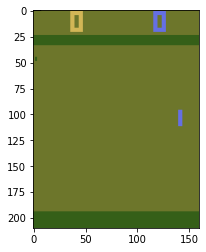

In [7]:
_s = env.reset()
plt.imshow(env.render())

In [8]:
env.time_step_spec().observation

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [9]:
env.time_step_spec().observation

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [10]:
env.time_step_spec().reward

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

In [11]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)

In [12]:
time_step = env.step(2)

/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


In [13]:
time_step = env.reset()
# print(time_step)

## ☑️ 2.2 Создание окружений для обучения

In [14]:
# Загрузка через gym, нужно указать сколько пропускаем фреймов
train_gym = gym.make('ALE/Pong-v5', render_mode='rgb_array', new_step_api=False, frameskip=frame_skip)
train_gym = gym.wrappers.gray_scale_observation.GrayScaleObservation(train_gym, keep_dim=True)
train_gym = FireOnReset(train_gym)
train_gym = FrameStack4(train_gym)
train_gym = GymWrapper(gym_env = train_gym)
train_env = tf_py_environment.TFPyEnvironment(train_gym)

eval_gym = gym.make('ALE/Pong-v5', render_mode='rgb_array', new_step_api=False, frameskip=frame_skip)
eval_gym = gym.wrappers.gray_scale_observation.GrayScaleObservation(eval_gym, keep_dim=True)
eval_gym = FireOnReset(eval_gym)
eval_gym = FrameStack4(eval_gym)
eval_gym = GymWrapper(gym_env = eval_gym)
eval_env = tf_py_environment.TFPyEnvironment(eval_gym)

train_gym.spec

EnvSpec(id='ALE/Pong-v5', entry_point='gym.envs.atari:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=27000, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'game': 'pong', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 8, 'render_mode': 'rgb_array'}, namespace='ALE', name='Pong', version=5)

In [15]:
# для визуализации (видео)
eval_py_env = suite_gym.load(environment_name=env_name, )

In [16]:
train_env.batch_size

1

# 3️⃣ Агент
* Агент - алгоритм, который решет RL задачу. `DQN agent` - можно использовать в любом окружении с дискретным набором действий. В основе лежит `QNetwork`, сеть которая может вычислять `QValues` (expected returns) для всех действий доступных в окружении.
* `tf_agents.specs.from_spec` - что может делать агент, переводит переданную спецификацию в `TensorSpecs`.
* `dqn_agent` - объект в котором реализован алгоритм.
    * [Документация](https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent)
    * `time_step_spec` см.выше (Среда).
    * `action_spec` см.выше (Агент).
    * `q_network` - сеть должна взвращать логиты, вызывается через `call`.
    * `optimizer` - оптимизатор
    *  `td_errors_loss_fn` - loss
        * A function for computing the TD errors loss.
        * If None, a default value of element_wise_huber_loss is used.
        * This function takes as input the target and the estimated Q values and returns the loss for each element of the batch.
        * `common.element_wise_squared_loss`
    * `train_step_counter` - An optional counter to increment every time the train op is run. Defaults to the global_step.
* `tf_agents.networks.sequential` - преобразует tf сеть в сеть с которой может работать агент

In [17]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))

In [18]:
from tf_agents.specs import tensor_spec
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.networks import sequential

## ☑️ 3.1 Создание агента

In [19]:
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
action_tensor_spec

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))

In [20]:
# QNetwork - tf.keras.Sequential([])
model = [
    tf.keras.layers.InputLayer(input_shape=(210, 160, 4), name='MainInput'),
    # Препроцессинг: 
      # обрезка кадра - интерфейс и счёт; оставляем квадрат; сжимаем до 40x40;
      # измененяем int -> float иначе падает на CNN слое.
    tf.keras.layers.Lambda(lambda s: tf.image.crop_to_bounding_box(image=s, offset_height=33, 
                                      offset_width=0, target_height=160, 
                                      target_width=160)),
    tf.keras.layers.Resizing(height=40, width=40),
    tf.keras.layers.Lambda(lambda s: tf.cast(s, dtype=tf.float32) / 255.),

    # Обработка изображения
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(4,4),
                           activation='relu',),
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(2,2),
                           activation='relu',),
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(2,2),
                           activation='relu',),
    tf.keras.layers.Conv2D(filters=1, 
                           kernel_size=(2,2),
                           activation='relu',),
    
    # Выход из сети: количество доступных действий ограничены 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512,
                          activation='relu',),
    tf.keras.layers.Dense(units=num_actions,
                          activation=None),
]

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Создаётся сеть для агента (принимает список слоёв)
q_net = sequential.Sequential(model)

In [21]:
# возвращает тензор того же типа, что и lr
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/polynomial_decay
epsilon = tf.compat.v1.train.polynomial_decay(
    learning_rate     = start_epsilon,
    global_step       = global_step,
    decay_steps       = n_of_steps,
    end_learning_rate = end_epsilon)

In [22]:
train_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(210, 160, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [23]:
# Агент
tf_agent = dqn_agent.DqnAgent(
    time_step_spec       = train_env.time_step_spec(),
    action_spec          = train_env.action_spec(),
    q_network            = q_net,
    optimizer            = optimizer,
    td_errors_loss_fn    = common.element_wise_squared_loss,
#     td_errors_loss_fn    = common.element_wise_huber_loss
    train_step_counter   = global_step,
    epsilon_greedy       = epsilon, #0.1
    gamma                = gamma,
    n_step_update        = n_step_update,
    target_update_period = target_update_period, #100
)

tf_agent.initialize()

2022-08-28 11:30:36.634577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [24]:
# train_sequence_length # Атрибут, сколько кадров подаётся в train (N+1), для dataset
tf_agent.train_sequence_length

30

In [25]:
q_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 210, 160, 4)]     0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
resizing (Resizing)          multiple                  0         
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  2080      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  8256      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  1

# 4️⃣ Политика

Политика - определяет как агент действует в среде, обучение идёт до тех пор пока политика не будет приводить к желаемому результату.

Политка:
* Желаемый результат - не пропускать шарик.
* Политика возвращает действие (влево или вправо) для каждого наблюдения `time_step`.

Агенты содержат две политики:
* `agent.policy` - основная политика, которая используется для оценки и развёртывания.
* `agent.collect_policy` - вторая политика, которая используется для сбора данных (для буффера)

Примеры политик:
* `random_tf_policy` - выбрать любое действие - возвращается объект `PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())`

In [26]:
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import fixed_policy

from tf_agents.trajectories import time_step as ts

## ☑️ 4.1 Примеры политик

In [27]:
train_env.time_step_spec()
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))

## ☑️ 4.2 Сохраним политики для цикла обучения

In [28]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

# random - для прогрева
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                    train_env.action_spec())
print(eval_policy)
print(collect_policy)
print(random_policy)

# 5️⃣ Метрики и оценка Агента
Чаще всего используют среднее вознаграждение.

In [29]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# 6️⃣ Replay Buffer
Накапливаем "кадры" - https://github.com/tensorflow/agents/blob/master/docs/tutorials/5_replay_buffers_tutorial.ipynb
* Буферы собирают `trajectories of experience`.
* Основые атрибуты:
    * `data_spec` - A spec or a list/tuple/nest of specs describing a single item that can be stored in this buffer.
        * при инициализации можно передать `TensorSpec` -  `agent.collect_data_spec`
    * `capacity` ёмкость буфера.
* `TFUniformReplayBuffer` - универсальный буфер, хранит "кадры" указанной длины, сборанные в батчи.
    * `replay_buffer.add_batch(values_batched)` - добавление элементов в буфер.
    * `get_next()` - получить следующй батч
    * `as_dataset()` - сделать Dataset.
    
*Прим. Если можно накопить "кадры" (состояния) и не нужно много взаимодействовать со средой, то можно использовать буфер без драйвера т.е. можем сгенерировать много разных действий и их выучить, "как-бы" не оказывая влияния на среду через агента. Кадры генерятся по политике, и не нужно эту политику "автоматически" корректировать.*

## ☑️ 6.1 Создаём Буфер

In [30]:
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory

In [31]:
# Размер батча 1 т.к. у нас окружение 1 (не собрано в батч окружений)
batch_size = train_env.batch_size # 1

replay_buffer = TFUniformReplayBuffer(
    data_spec  = tf_agent.collect_data_spec,
    batch_size = batch_size,
    max_length = replay_buffer_max_length)

print(train_env.batch_size)
print(replay_buffer.capacity)

2022-08-28 11:30:43.148908: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3360000000 exceeds 10% of free system memory.


1
tf.Tensor(25000, shape=(), dtype=int64)


In [32]:
# Набор данных в буфер, происходит по одному "кадру"
def collect_step(environment, policy, buffer):
  # получаем состояние среды
  time_step = environment.current_time_step()
  # применяем политику - получаем PolicyStep
  action_step = policy.action(time_step)
  # применяем полученный шаг к окружаюшей среде
  next_time_step = environment.step(action_step.action)
  # собирается объект - отдельные транзакции собираются в траекторию, нужна для драйвера, эффективное хранение
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  # Записываем цепочку в буфер
  buffer.add_batch(traj)

    
# Набор данных для обучения, добавляет N кадров в буфер
def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [33]:
if 0:
    # Инициализация буфера, политика рандомная
    collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

## ☑️ 6.2 Пример работы с Буфером

In [34]:
if 0:
    # Наполнение буфера - политика Рандом
    collect_data(train_env, random_policy, replay_buffer, initial_collect_steps=1000)
    

    # sample_batch_size - размер батча
    # num_parallel_calls - разпараллерирование
    # num_steps - возвращает "подэпизоды", последовательные кадры
    dataset = replay_buffer.as_dataset(
        num_parallel_calls = 3,
        sample_batch_size  = 1,
        num_steps          = tf_agent.train_sequence_length)

    dataset = dataset.prefetch(prefetch_size)
    # Создаём итератор для цикла обучения
    iterator = iter(dataset)

In [35]:
# Пример работы итератера
if 0:
    s = next(iterator)
    print('Действия', s[0].action[0])
    print('Награды', s[0].reward[0])
    plt.imshow(s[0].observation[0][25])

# 7️⃣ Драйвер - цикл для агента (взаимодействие с средой и наполнение Буфера)

Обеспечивает цикл - выполнения политики в среде т.е. выполняет в среде действие, а полученный результат передаётся в буфер и метрики. 
* В буфер пападают Траектории - `Trajectory` которые включают:
 * the action recommended by the policy,
 * the reward obtained,
 * the type of the current and the next step.

Драйвер будет выполнять действия, пока не достигнит установленного лимита:
* количество шагов.
* количество сыгранных игр.

Драйвер выполняет действия в окружении, каждый раз когда он запускается игра продолжается на том же моменте что и была. Драйвер возвращает последнее состояние среды (после пройденных шагов).

Каждый шаг записывается в буффер.

Выполняет N шагов: Задаётся:
* `env` - окружение
* `policy` - политика
* `observers` - наблюдения, которые можно получать от среды в т.ч. из буфера.
* `max_steps` - максимальное количество шагов.
* `max_episodes` - максимальное количество эпизодов.

*Прим. Если нужно много взаимодействовать со средой, то можно использовать драйвер, и не накапливать буфер.*

In [36]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics

In [37]:
# метрики
train_metrics = [
            tf_metrics.EnvironmentSteps(),
            tf_metrics.AverageReturnMetric(),
]

# Выбираем буфер
replay_observer = [replay_buffer.add_batch]

driver = dynamic_step_driver.DynamicStepDriver(
            env       = train_env,
            policy    = collect_policy,                 # Политика для набора данных
            observers = replay_observer + train_metrics,
            num_steps = num_steps_agent_do_in_env
)




if 0:
    # Запуск драйвера
    final_time_step, policy_state = driver.run()
    print('final_time_step', final_time_step)
    print('Количество кадров в буфере', replay_buffer.num_frames)
    # replay_buffer.clear()
    plt.imshow(np.squeeze(final_time_step[3]))

# ☑️ Продолжение обучения с точки остановки
1. Нужно создать всё что выше, в т.ч. политику
2. Создать `checkpointer` указав папку.
3. Восстановиться `train_checkpointer.initialize_or_restore()`

In [38]:
!ls -all -lh ../input/rf-model/checkpoint

total 9.5M
drwxr-xr-x 2 nobody nogroup    0 Aug 28 11:28 .
drwxr-xr-x 3 nobody nogroup    0 Aug 28 11:28 ..
-rw-r--r-- 1 nobody nogroup  176 Aug 28 11:28 checkpoint
-rw-r--r-- 1 nobody nogroup 9.6M Aug 28 11:28 ckpt-555909.data-00000-of-00001
-rw-r--r-- 1 nobody nogroup 4.0K Aug 28 11:28 ckpt-555909.index


In [39]:
if 1:
    from tf_agents.utils import common
    
    train_checkpointer = common.Checkpointer(
    ckpt_dir    = '../input/rf-model/checkpoint',
    agent       = tf_agent,
    policy      = tf_agent.policy,)
    
    
    train_checkpointer.initialize_or_restore()
    print(f'⚠️{global_step}⚠️')

⚠️<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=555909>⚠️


# 8️⃣ Обучение Агента

In [40]:
from datetime import datetime, timedelta

def logs_interval(step, log_interval=100, eval_interval=1000, num_eval_episodes=3):
    """step - текущий шаг обучения;
    log_interval - выводить лог каждый N шаг;
    eval_interval - делать оценку агента (прогон по другому окружению) каждый N шаг;
    num_eval_episodes - сколько игр сыграть (до счёта 21)
    """
    if step % log_interval == 0:
        cur_time = (datetime.now()+timedelta(hours=3)).strftime('%H:%M:%S')
        print('step = {0}: loss = {1}, time = {2}'.format(step, train_loss.loss, cur_time))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        cur_time = (datetime.now()+timedelta(hours=3)).strftime('%H:%M:%S')
        print('step = {0}: Average Return = {1}. time = {2}'.format(step, avg_return, cur_time))

## ☑️ "Прогрев" Агента

Обучение Агента на рандомной политике

In [41]:
if 0:
    # Загружам в буфер данные 10k (initial_collect_steps) рандомная политика.
    collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
    # Из буфера создаётся набор для обучения,
    # Итератор будет отдавать указанное количество кадров (tf_agent.train_sequence_length) - сет
    # Сеты собраны в Батчи
    dataset = replay_buffer.as_dataset(
        num_parallel_calls = 3,
        sample_batch_size  = batch_size_dataset,
        num_steps          = tf_agent.train_sequence_length)
    dataset = dataset.prefetch(prefetch_size)
    iterator = iter(dataset)

In [42]:
print('В буфере записано: ', replay_buffer.num_frames())

if 0:
    print(replay_buffer.clear())
    print('В буфере записано: ', replay_buffer.num_frames())

В буфере записано:  tf.Tensor(0, shape=(), dtype=int64)


In [43]:
buffer_game_size = 50_000

# Приблизительное время на обучение для обработки 100 эпизодов
gpu_sec_to_100op = 10 / 100
cpu_sec_to_100op = 30 / 100


minute_gpu = (buffer_game_size * gpu_sec_to_100op) / 60 # GPU
minute_cpu = (buffer_game_size * cpu_sec_to_100op) / 60 # CPU

print(f'Время на обучение по Рандомной политике мин.: GPU - {minute_gpu}, CPU - {minute_cpu}')

Время на обучение по Рандомной политике мин.: GPU - 83.33333333333333, CPU - 250.0


In [44]:
if 0:
    for _ in range(buffer_game_size):
        # Получаем набор кадров из итератера и передаём в агента
          # (Батч, Набор кадров до гола(10); Высота картинки; Ширина картинки; Объединённые 4 кадра)
        trajectories, _ = next(iterator)
        train_loss = tf_agent.train(experience=trajectories)
        # Инкремент, обновляет номер шага
        global_step = tf_agent.train_step_counter.numpy()
        
        logs_interval(global_step, 100, 1000)

*Промежуточный результат обучения сохраним (ниже есть код для сохранения)*  
*Счётчик цикла обучения сбросим на ноль, чтобы корректно считалась Epsilon.*

## ☑️ Обучение агента - политика "Epsilon"

После "прогрева" агента (он должен был изучить среду), начинаем учить на epsilon-gready политике и постепенно снижаем случайность выбора действия

In [45]:
agent_game_size = 1000  # обучится на N наборов
reRun           = 5     # добавить новых наборов N*шаги_в_драйвере

gpu_sec_to_100op = 10 / 100
cpu_sec_to_100op = 120 / 100

minute_gpu = (agent_game_size * reRun * gpu_sec_to_100op ) / 60
minute_cpu = (agent_game_size * reRun * cpu_sec_to_100op) / 60

print(f'Время на обучение по Драйверу политике мин.: GPU - {minute_gpu}; {minute_gpu / 60} - час.')
print(f'Время на обучение по Драйверу политике мин.: CPU - {minute_cpu}; {minute_cpu / 60} - час.')

Время на обучение по Драйверу политике мин.: GPU - 8.333333333333334; 0.1388888888888889 - час.
Время на обучение по Драйверу политике мин.: CPU - 100.0; 1.6666666666666667 - час.


In [46]:
print('В буфере записано: ', replay_buffer.num_frames())
print('Драйвер будет добавлять при запуске: ', driver._num_steps)

В буфере записано:  tf.Tensor(0, shape=(), dtype=int64)
Драйвер будет добавлять при запуске:  2000


In [47]:
print('Текущий шаг обучения:', tf_agent.train_step_counter.numpy())

Текущий шаг обучения: 555909


In [48]:
# ⚠️Запустить, если возобновляешь обучение
if 1:
    dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3,
    sample_batch_size  = batch_size_dataset,
    num_steps          = tf_agent.train_sequence_length)
    dataset = dataset.prefetch(prefetch_size)
    iterator = iter(dataset)

2022-08-28 11:30:49.023611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [49]:
# для логов
cur_time_fn = lambda: str((datetime.now()+timedelta(hours=3)).strftime('%H:%M:%S'))


if 1:
    # Запуск драйвера, он выполняет действия по политике и наполняет буфер
    final_time_step, policy_state = driver.run()
    final_time_step, _ = driver.run(final_time_step, policy_state)
    final_time_step, _ = driver.run(final_time_step, policy_state)
    
    for i in range(reRun):
        print(f'Начался цикл обучения {i+1} из {reRun} (шаги {agent_game_size}): {cur_time_fn()}')
        for _ in range(agent_game_size):
            # Обучение агента по накопленному в буфере данным
            trajectories, _ = next(iterator)
            train_loss = tf_agent.train(experience=trajectories)
            global_step = tf_agent.train_step_counter.numpy()

            logs_interval(global_step, 1000, 5000)
    
        # Запускается драйвер с последнего состояния для добавления новых действий
        print(f'Запуск драйвера: {cur_time_fn()}')  
        final_time_step, _ = driver.run(final_time_step, policy_state)  
        print(f'Остановка драйвера: {cur_time_fn()}')
    
    print('⚠️Цикл обучения завершён⚠️')

Начался цикл обучения 1 из 5 (шаги 1000): 14:32:46
step = 556000: loss = 0.44795286655426025, time = 14:33:10
Запуск драйвера: 14:36:56
Остановка драйвера: 14:37:33
Начался цикл обучения 2 из 5 (шаги 1000): 14:37:33
step = 557000: loss = 0.3535398840904236, time = 14:37:56
Запуск драйвера: 14:41:41
Остановка драйвера: 14:42:19
Начался цикл обучения 3 из 5 (шаги 1000): 14:42:19
step = 558000: loss = 0.420687735080719, time = 14:42:42
Запуск драйвера: 14:46:27
Остановка драйвера: 14:47:04
Начался цикл обучения 4 из 5 (шаги 1000): 14:47:04
step = 559000: loss = 0.3732653260231018, time = 14:47:27
Запуск драйвера: 14:51:12
Остановка драйвера: 14:51:50
Начался цикл обучения 5 из 5 (шаги 1000): 14:51:50
step = 560000: loss = 0.25804513692855835, time = 14:52:12
step = 560000: Average Return = -9.0. time = 14:52:45
Запуск драйвера: 14:56:29
Остановка драйвера: 14:57:06
⚠️Цикл обучения завершён⚠️


# 9️⃣ Визуализация обученного агента

In [50]:
import imageio
import base64
import IPython


def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)



def create_policy_eval_video(policy, filename, num_episodes=2, fps=25):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(np.squeeze(eval_env.render()))
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(np.squeeze(eval_env.render()))
  return embed_mp4(filename)


create_policy_eval_video(tf_agent.policy, "trained-agent")

/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."
/opt/conda/lib/python3.7/site-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())
/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is depreca

# 🔟 Чекпоинты (сохранение)

In [51]:
!rm -r ./checkpoint
!ls -all -lh ./

rm: cannot remove './checkpoint': No such file or directory
total 504K
drwxr-xr-x 2 root root 4.0K Aug 28 11:57 .
drwxr-xr-x 6 root root 4.0K Aug 28 11:28 ..
---------- 1 root root 345K Aug 28 11:57 __notebook__.ipynb
-rw-r--r-- 1 root root 146K Aug 28 11:57 trained-agent.mp4


In [52]:
from tf_agents.utils import common
import os

# https://stackoverflow.com/questions/65448313/cant-load-saved-policy-tf-agents
train_checkpointer = common.Checkpointer(
    ckpt_dir    = './checkpoint',
    agent       = tf_agent,
    policy      = tf_agent.policy,
)

train_checkpointer.save(global_step)

import shutil
shutil.make_archive(base_name='checkpoint', format='zip', base_dir='./checkpoint')

'checkpoint.zip'

In [53]:
!ls -all -lh ./checkpoint

total 9.6M
drwxr-xr-x 2 root root 4.0K Aug 28 11:57 .
drwxr-xr-x 3 root root 4.0K Aug 28 11:57 ..
-rw-r--r-- 1 root root  176 Aug 28 11:57 checkpoint
-rw-r--r-- 1 root root 9.6M Aug 28 11:57 ckpt-560909.data-00000-of-00001
-rw-r--r-- 1 root root 4.0K Aug 28 11:57 ckpt-560909.index


# ☑️ Средний счёт на 100 игр

In [54]:
avg_return = compute_avg_return(eval_env, tf_agent.policy, 100)

print(f'Средний счёт за 100 игр: {avg_return}')

Средний счёт за 100 игр: -12.199999809265137
